# Sentiment Analysis of Amazon Kindle Reviews

In [1]:
import numpy as np
import pandas as pd
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
from matplotlib import gridspec
%matplotlib inline

### Defining a class to extract and clean data

In [2]:
class PreprocessData:
    def __init__(self, datafile):
        self.datafile = datafile
        self.data = pd.read_csv(datafile).fillna('')
        self.data.Rating = self.data.Rating.apply(lambda x: int(x))
        
    
    def binarise(self):
        """
        Converts star ratings into 1 (3+ stars) or 0
        
        """
        self.data.Rating = np.where(self.data.Rating>=3, 1, 0)
        
    
    def unify_columns(self):
        """
        Merges Title and Review columns
        
        """
        self.data['Corpus'] = self.data.Title + ' ' + self.data.Review
        self.data.drop(['Title', 'Review'], axis=1, inplace=True)
        
        
    def remove_stopwords(self, stem=False):
        """
        Removes stop words and numbers from strings. Stems each word using NLTK's PorterStemmer

        Required modules: nltk, re

        """
        def rmstp(feature, stem=stem):
            tokens = word_tokenize(feature)
            stop_words = stopwords.words('english') + \
                       [u'ive', u'dont', u'wouldnt', u'im', u'couldnt', u'shouldnt',
                        u'cant',u'also', u'one', u'even', u'mightnt',
                        u'mustnt', u'neednt', u'amazon', u'kindle']
            if stem:
                stemmer = PorterStemmer()
                stemmed_words = ' '.join([stemmer.stem(token) for token in tokens
                                          if token not in stop_words
                                          and not bool(re.search(r'\d', token))])
                return stemmed_words

            unstemmed_words = ' '.join([token for token in tokens
                                         if token not in stop_words
                                         and not bool(re.search(r'\d', token))])
            return unstemmed_words
        
        try:
            self.data.Title = self.data.Title.apply(rmstp)
            self.data.Review = self.data.Review.apply(rmstp)
        except AttributeError:
            self.data.Title = self.data.Corpus.apply(rmstp)
    
    
    def word_cloud(self, pos_neg_split=False):
        """
        Generates a word map
        
        """
        stopwords = STOPWORDS.copy()
        if pos_neg_split:
            stopwords.add("book")
            stopwords.add("books")
            stopwords.add("read")

            pos_rev = ' '.join(self.data.Corpus.where(self.data.Rating==1).dropna().tolist())
            neg_rev = ' '.join(self.data.Corpus.where(self.data.Rating==0).dropna().tolist())

            wordcloud_pos = WordCloud(max_font_size=50, relative_scaling=.5,
                                      stopwords=stopwords).generate(pos_rev)
            plt.figure(figsize=(15, 15), dpi=80)
            gs = gridspec.GridSpec(1, 2)
            plt.subplot(gs[0, 0])
            plt.imshow(wordcloud_pos)
            plt.axis("off")
            plt.title('Positive Reviews', fontsize=18)

            wordcloud_neg = WordCloud(max_font_size=50, relative_scaling=.5,
                                      stopwords=stopwords).generate(neg_rev)
            plt.subplot(gs[0, 1])
            plt.imshow(wordcloud_neg)
            plt.axis("off")
            plt.title('Negative Reviews', fontsize=18)
            
        else:
            rev = ' '.join(self.data.Corpus.dropna().tolist())
            wordcloud_all = WordCloud(max_font_size=50, relative_scaling=.5, stopwords=stopwords).generate(rev)
            plt.figure(figsize=(15, 15))
            plt.imshow(wordcloud_all)
            plt.axis("off")
            plt.title('All Reviews', fontsize=18)
            
            

## 1. Word Cloud

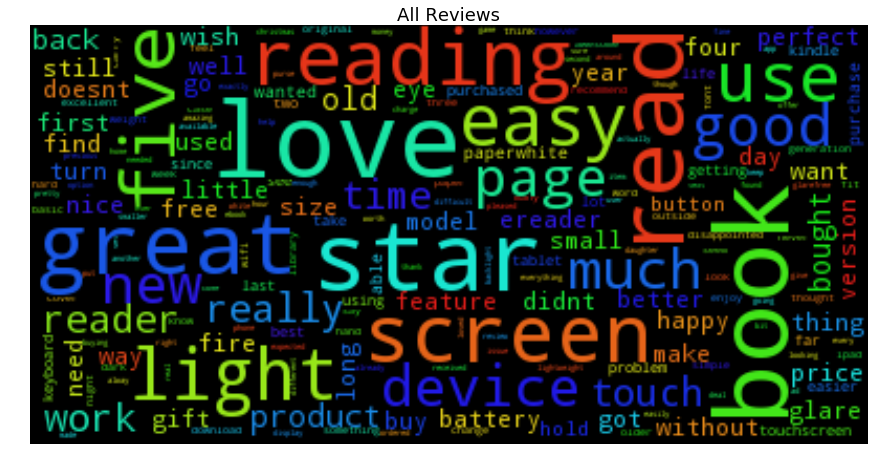

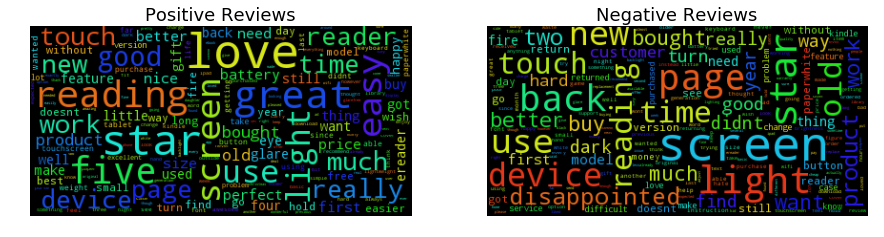

In [3]:
words = PreprocessData('kindle_reviews.csv')
words.binarise()
words.remove_stopwords()
words.unify_columns()
words.word_cloud()
words.word_cloud(pos_neg_split=True)

## 2. Binary Classification

We are going to generate three datasets:
- One using only Titles and Reviews without any processing
- One excluding stop words
- One excluding stop words and stemming remaining words

These datasets are then going to be used to train a number of supervised learning algorithms. Accuracies are going to be compared to determine whether extra computing power is justified by stemming and removing stop words. Also, they will be used to find the best algorithm for the given classification task.

In [4]:
# remove stopwords and numbers, stem letters, merge columns
data_nostop_stemmed = PreprocessData('kindle_reviews.csv')
data_nostop_stemmed.binarise()
data_nostop_stemmed.remove_stopwords(stem=True)
data_nostop_stemmed.unify_columns()
data_nostop_stemmed = data_nostop_stemmed.data

# remove stopwords and numbers, merge columns
data_nostop = PreprocessData('kindle_reviews.csv')
data_nostop.binarise()
data_nostop.remove_stopwords()
data_nostop.unify_columns()
data_nostop = data_nostop.data

# merge columns
data_raw = PreprocessData('kindle_reviews.csv')
data_raw.binarise()
data_raw.unify_columns()
data_raw = data_raw.data

### Splitting the data into Train and Test sets

In [5]:
from sklearn.cross_validation import train_test_split

stm_train, stm_test = train_test_split(data_nostop_stemmed[['Corpus', 'Rating']], test_size=0.33)
    
ns_train, ns_test = train_test_split(data_nostop[['Corpus', 'Rating']], test_size=0.33)
    
raw_train, raw_test = train_test_split(data_raw[['Corpus', 'Rating']], test_size=0.33)

### Vectorising the features using Tf-Idf Vectoriser

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()

### 1.1 Multinomial Naive Bayes

In [7]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
clf = MultinomialNB()

#### Raw data

In [8]:
raw_train_matrix = vectorizer.fit_transform(raw_train.Corpus)
raw_train_label = raw_train.Rating

raw_test_matrix = vectorizer.transform(raw_test.Corpus)
raw_test_label = raw_test.Rating

clf.fit(raw_train_matrix, raw_train_label)
raw_pred = clf.predict(raw_test_matrix)

raw_acc = accuracy_score(raw_test_label, raw_pred)
raw_f1 = f1_score(raw_test_label, raw_pred)
raw_prec = precision_score(raw_test_label, raw_pred)
raw_rec = recall_score(raw_test_label, raw_pred)

print('Raw Data Accuracy: {0:.2f}%'.format(raw_acc*100))
print('Raw Data Precision Score: {0:.2f}%'.format(raw_prec*100))
print('Raw Data Recall Score: {0:.2f}%'.format(raw_rec*100))
print('Raw Data F1 Score: {0:.4f}'.format(raw_f1))

Raw Data Accuracy: 87.42%
Raw Data Precision Score: 87.35%
Raw Data Recall Score: 100.00%
Raw Data F1 Score: 0.9325


#### Removing stop words

In [9]:
ns_train_matrix = vectorizer.fit_transform(ns_train.Corpus)
ns_train_label = ns_train.Rating

ns_test_matrix = vectorizer.transform(ns_test.Corpus)
ns_test_label = ns_test.Rating

clf.fit(ns_train_matrix, ns_train_label)
ns_pred = clf.predict(ns_test_matrix)

ns_acc = accuracy_score(ns_test_label, ns_pred)
ns_f1 = f1_score(ns_test_label, ns_pred)
ns_prec = precision_score(ns_test_label, ns_pred)
ns_rec = recall_score(ns_test_label, ns_pred)

print('No Stopwords Accuracy: {0:.2f}%'.format(ns_acc*100))
print('No Stopwords Precision Score: {0:.2f}%'.format(ns_prec*100))
print('No Stopwords Recall Score: {0:.2f}%'.format(ns_rec*100))
print('No Stopwords F1 Score: {0:.4f}'.format(ns_f1))

No Stopwords Accuracy: 87.90%
No Stopwords Precision Score: 87.78%
No Stopwords Recall Score: 100.00%
No Stopwords F1 Score: 0.9349


#### Stemming the words

In [10]:
stm_train_matrix = vectorizer.fit_transform(stm_train.Corpus)
stm_train_label = stm_train.Rating

stm_test_matrix = vectorizer.transform(stm_test.Corpus)
stm_test_label = stm_test.Rating

clf.fit(stm_train_matrix, stm_train_label)
stm_pred = clf.predict(stm_test_matrix)

stm_acc = accuracy_score(stm_test_label, stm_pred)
stm_f1 = f1_score(stm_test_label, stm_pred)
stm_prec = precision_score(stm_test_label, stm_pred)
stm_rec = recall_score(stm_test_label, stm_pred)

print('Stemmed Accuracy: {0:.2f}%'.format(stm_acc*100))
print('Stemmed Precision Score: {0:.2f}%'.format(stm_prec*100))
print('Stemmed Recall Score: {0:.2f}%'.format(stm_rec*100))
print('Stemmed F1 Score: {0:.4f}'.format(stm_f1))

Stemmed Accuracy: 86.65%
Stemmed Precision Score: 86.63%
Stemmed Recall Score: 100.00%
Stemmed F1 Score: 0.9284


### TBC...